# Models for Anomaly Detection
### 1. One-class SVM
### 2. Isolation Forest
### 3. Local Outlier Factor
### 4. AutoEncoder

### Training on Local Machine

In [8]:
import os

original_working_directory_path = os.getcwd()
print("The original working directory is {0}".format(os.getcwd()))

def to_original_working_directory():
    os.chdir(original_working_directory_path)
    print(f"Changed to original working directory {original_working_directory_path}")

The original working directory is /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_02


In [9]:
def to_root_working_directory():
    root_working_directory_path = os.path.join(original_working_directory_path, "../..")
    os.chdir(root_working_directory_path)
    print(f"Changed to root working directory {os.getcwd()}")

In [10]:
to_root_working_directory()

Changed to root working directory /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


In [1]:
from enum import Enum

class Behavior(Enum):
    NORMAL = "normal"
    ROOTKIT_BDVL = "bdvl"
    ROOTKIT_BEURK = "beurk"
    CNC_BACKDOOR_JAKORITAR = "backdoor_jakoritar"
    CNC_THETICK = "the_tick"
    CNC_OPT1 = "data_leak_1"
    CNC_OPT2 = "data_leak_2"
    RANSOMWARE_POC = "ransomware_poc"


In [3]:
import pandas as pd

dataset = pd.read_csv('dataset-01.csv')        

In [4]:
print(f"Full length of dataset: {len(dataset)}")

Full length of dataset: 59004


In [5]:
# Dropping time status features
time_status_columns = ['time', 'timestamp', 'seconds']
try:
    dataset.drop(time_status_columns, inplace=True, axis=1)
except:
    print(f"All time status features {(time_status_columns)} are removed from the dataset")

In [6]:
from fast_ml.feature_selection import get_constant_features

# Removing constant features
constant_features = set(get_constant_features(dataset, threshold=0.99, dropna=False)['Var'])
try:
    dataset.drop(constant_features, inplace=True, axis=1)
except:
    print(f"All constant features {(constant_features)} are removed from the dataset")

In [7]:
from sklearn.preprocessing import MinMaxScaler
# Scaling
fit_normal_behavior_only = True
standard_scaling = False
if standard_scaling:
    scaler = StandardScaler()
else:
    scaler = MinMaxScaler()
    
print(f"Using {scaler}")

if fit_normal_behavior_only: 
    scaler.fit(dataset[dataset['behavior'] == "Behavior.NORMAL"].values[:,:-1])
else: 
    scaler.fit(dataset.values[:,:-1])

scaled_dataset = pd.DataFrame(scaler.transform(dataset.values[:,:-1]), columns=dataset.columns.drop("behavior"), index=dataset.index)
scaled_dataset["behavior"] = dataset["behavior"]

Using MinMaxScaler()


In [19]:
for behavior in Behavior:
    n_samples = len(scaled_dataset.loc[scaled_dataset['behavior'] == f"{behavior}"])
    print(f"{behavior} => {n_samples} samples")

Behavior.NORMAL => 14702 samples
Behavior.ROOTKIT_BDVL => 5698 samples
Behavior.ROOTKIT_BEURK => 7358 samples
Behavior.CNC_BACKDOOR_JAKORITAR => 4312 samples
Behavior.CNC_THETICK => 7704 samples
Behavior.CNC_OPT1 => 5687 samples
Behavior.CNC_OPT2 => 4162 samples
Behavior.RANSOMWARE_POC => 9381 samples


In [23]:
# Calculate degree of contamination
n_abnormal_samples = len(scaled_dataset.loc[scaled_dataset['behavior'] != "Behavior.NORMAL"])
n_total_samples = len(scaled_dataset)
print(n_abnormal_samples/n_total_samples)

0.750830452172734


In [32]:
def relabel(df, normal_label, abnormal_label):
    relabeled_df = df.copy(deep=True)
    relabeled_df['behavior'] = relabeled_df['behavior'].map(lambda b: normal_label if b == "Behavior.NORMAL" else abnormal_label)
    return relabeled_df

In [33]:
svm_dataset = relabel(scaled_dataset, normal_label=1, abnormal_label=-1)

In [36]:
from sklearn.model_selection import train_test_split

svm_training_data, svm_test_data = train_test_split(svm_dataset, test_size=0.2, random_state=42, shuffle=True)
print(len(svm_training_data))
print(len(svm_test_data))

47203
11801


In [146]:
X_normal = scaled_dataset.loc[scaled_dataset['behavior'] == "Behavior.NORMAL"].drop(["behavior"],  axis=1).to_numpy()
X_normal.shape

(14702, 85)

In [ ]:
import numpy as np

def get_test_datasets(test_data, normal_label, abnormal_label):
    test_data_dict = {}
    test_data_flat = np.zeros([0, 47])

    for behavior, behavior_data in test_data.items():
        if behavior == Behavior.NORMAL:
            behavior_data = behavior_data[:2800]
            behavior_data[:, -1] =  1
        else:
            behavior_data = behavior_data[:400]
            behavior_data[:, -1] =  -1

        test_data_dict[behavior] = behavior_data
        test_data_flat = np.vstack([test_data_flat, behavior_data])

    return test_data_dict, test_data_flat

### Functions

In [226]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate(model, data_dict, tablefmt='latex_raw'):
        results = []
        labels= [-1,1]
        pos_label = 1
        
        y_true_total = np.empty([0])
        y_pred_total = np.empty([0])
        for behavior, data in data_dict.items():
            y_true = data[:,-1].astype(int)
            y_true_total = np.concatenate((y_true_total, y_true))

            y_pred = model.predict(data[:, :-1].astype(np.float32))
            y_pred_total = np.concatenate((y_pred_total, y_pred))

            accuracy = accuracy_score(y_true, y_pred)

            n_samples = len(y_true)
            results.append([behavior.name.replace("_", "\_"), f'{(100 * accuracy):.2f}\%', '\\notCalculated', '\\notCalculated', '\\notCalculated', str(n_samples)])

        accuracy = accuracy_score(y_true_total, y_pred_total)
        precision = precision_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        recall = recall_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        f1 = f1_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        n_samples = len(y_true_total)
        results.append(["GLOBAL", f'{(100 * accuracy):.2f}\%', f'{(100 * precision):.2f}\%', f'{(100 * recall):.2f}\%', f'{(100 * f1):.2f}\%', n_samples])
        print(tabulate(results, headers=["Behavior", "Accuracy", "Precision", "Recall", "F1-Score", "\\#Samples"], tablefmt=tablefmt)) 

In [227]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [228]:
import pandas as pd

def convert_grid_search_result(grid_search_result, display_latex=True):
    df = pd.concat([pd.DataFrame(grid_search_result.cv_results_["mean_test_score"], columns=["mean_validation_accuracy"]), pd.DataFrame(grid_search_result.cv_results_["params"])],axis=1).sort_values(by=['mean_validation_accuracy'], ascending=False)
    df.index = np.arange(1, len(df) + 1)
    return df

In [229]:
import pandas as pd

def display_grid_search_result(df, n_items=10):
    print(df.head(n_items).to_latex(escape=True, bold_rows=True))

### Data Preparation

In [56]:
from src.data_provider import DataProvider

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(pi=3, scaling_minmax=True, scale_normal_only=True)

In [22]:
import numpy as np

def get_training_datasets(training_data_dict, normal_label, abnormal_label):
    training_data_50 = np.empty([0,47])
    training_data_80 = np.empty([0,47])
    for behavior, behavior_data in training_data_dict.items():

        if behavior == Behavior.NORMAL:
            behavior_data[:, -1] =  normal_label # SVM uses 1 for normal
            training_data_50 = np.concatenate([training_data_50, behavior_data[:7000,:]], axis=0)
            training_data_80 = np.concatenate([training_data_80, behavior_data[:8000,:]], axis=0)
        else:
            behavior_data[:, -1] =  abnormal_label # SVM uses -1 for outlier
            training_data_50 = np.concatenate([training_data_50, behavior_data[:1000,:]], axis=0)
            training_data_80 = np.concatenate([training_data_80, behavior_data[:286,:]], axis=0)

    return training_data_50, training_data_80

In [ ]:
import numpy as np

def get_test_datasets(test_data, normal_label, abnormal_label):
    test_data_dict = {}
    test_data_flat = np.zeros([0, 47])

    for behavior, behavior_data in test_data.items():
        if behavior == Behavior.NORMAL:
            behavior_data = behavior_data[:2800]
            behavior_data[:, -1] =  1
        else:
            behavior_data = behavior_data[:400]
            behavior_data[:, -1] =  -1

        test_data_dict[behavior] = behavior_data
        test_data_flat = np.vstack([test_data_flat, behavior_data])

    return test_data_dict, test_data_flat

## 4. Autoencoder

### 4.1 Autoencoder > PCA

In [241]:
from sklearn.decomposition import PCA

train_data_pca, test_data_pca, _ = DataProvider.get_flat_train_test_split(pi=3, scale_normal_only=False)

In [85]:
import matplotlib.pyplot as plt

X_train_std = train_data_pca[:, :-1]

pca = PCA(n_components=14)
pca.fit(train_data_pca_x)
X_train_pca = pca.fit_transform(X_train_std)

# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

In [ ]:
# Create the visualization plot
fontsize = 'x-large'
plt.figure(figsize=(12, 8))
plt.xticks(range(1, len(exp_var_pca)+1, 1))
plt.yticks(np.linspace(0,1,6))
plt.ylim(0,1)
plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center', color='blue', label='Individual Explained Variance')
plt.step(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid', color='red', label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio', fontsize=fontsize)
plt.xlabel('Principal Component Index', fontsize=fontsize)
plt.legend(loc='best', fontsize=fontsize)
plt.tight_layout()
plt.show()

In [36]:
cumulative_explained_variances = {}

for n_components in range (1, 21):
    pca = PCA(n_components=n_components)
    pca.fit(train_data_pca_x)
    X_train_pca = pca.fit_transform(X_train_std)
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.sum(explained_variance)
    cumulative_explained_variances[n_components] = cumulative_explained_variance

In [ ]:
x = list(cumulative_explained_variances.keys())
y = list(cumulative_explained_variances.values())

fontsize = 'x-large'
plt.figure(figsize=(12, 8))
plt.xlabel('Number of Principal Components', fontsize=fontsize)
plt.ylabel('Cumulative Explained Variance', fontsize=fontsize)
plt.xticks(x)
#plt.ylim(0,1)
#plt.axhline(y=0.95, color='black', linestyle='dashed', label='Threshold (95%)')
plt.plot(x, [0.95]*len(x), color='black', linestyle='dashed', label='Threshold (95%)')
plt.plot(x, y, color='blue', label='Cumulative Explained Variance')
plt.legend(loc='lower right', fontsize=fontsize)
plt.show()

# Train

In [248]:
import numpy as np

def get_test_datasets(df, normal_label, abnormal_label, subsampling=True):
    n_features = df.shape[1]
    test_data_dict = {}
    test_data_flat = np.zeros([0, n_features])

    for behavior in Behavior:
        behavior_samples = df.loc[df['behavior'] == str(behavior)].to_numpy()
        if behavior == Behavior.NORMAL:
            if subsampling: 
                behavior_samples = behavior_samples[:2800]
            behavior_samples[:, -1] = normal_label
        else:
            if subsampling: 
                behavior_samples = behavior_samples[:400]
            behavior_samples[:, -1] = abnormal_label

        test_data_dict[behavior] = behavior_samples
        test_data_flat = np.vstack([test_data_flat, behavior_samples])

    return test_data_dict, test_data_flat

In [249]:
from sklearn.model_selection import train_test_split

# Split equally into training data for ae and rl training
ae_training_data, rl_training_data = train_test_split(scaled_dataset, test_size=0.5, random_state=42, shuffle=True)
print(len(ae_training_data))
print(len(rl_training_data))

29502
29502


In [250]:
# We need X_train, X_valid, (X_test, y_test combined with evaluation data)
ae_normal_x = ae_training_data.loc[scaled_dataset['behavior'] == "Behavior.NORMAL"].drop(["behavior"],  axis=1).to_numpy().astype(np.float32)

threshold = int(0.6666*len(ae_normal_x))
ae_train_x = ae_normal_x[:threshold]
ae_valid_x = ae_normal_x[threshold:]

In [251]:
# Use the rl training data for testing and evaluation
evaluation_data, ae_test_data_flat = get_test_datasets(rl_training_data, normal_label=0, abnormal_label=1, subsampling=False)
print(len(ae_test_data_flat))

29502


In [254]:
ae_test_x = ae_test_data_flat[:,:-1].astype(np.float32)
ae_test_y = ae_test_data_flat[:,-1].astype(np.float32)
print(len(ae_test_y ))

29502


In [255]:
from torch import nn
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score
from tabulate import tabulate


class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    

class AutoEncoder(torch.nn.Module):
    

    def __init__(self, X_valid, X_test, y_test, evaluation_data, num_stds=[1], n_hidden_1=64, n_hidden_2=32, activation_function=nn.GELU(), batch_size: int = 64, verbose=False):

        super().__init__()
        
        validation_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_valid).type(torch.float),

        )
        self.validation_data_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=True, drop_last=True)

        self.X_test = X_test
        self.y_test = y_test
        
        self.evaluation_data = evaluation_data
        self.num_stds = num_stds
        
        n_features = X_valid.shape[1]
        
        self.model = nn.Sequential(
            nn.Linear(n_features, n_hidden_1),
            nn.BatchNorm1d(n_hidden_1),
            activation_function,
            nn.Linear(n_hidden_1, n_hidden_2),
            activation_function,
            #nn.Linear(32, 16),
            #activation_function,
            #nn.Linear(16, 32),
            #activation_function,
            nn.Linear(n_hidden_2, n_hidden_1),
            nn.BatchNorm1d(n_hidden_1),
            activation_function,
            nn.Linear(n_hidden_1, n_features),
            activation_function
        )
        self.threshold = None
        self.loss_mean = None
        self.loss_standard_deviation = None
        
        self.verbose = verbose

        
    def forward(self, X):
        return self.model(X)
    
    
    def pretrain(self, X_train, optimizer=torch.optim.SGD, loss_function=torch.nn.MSELoss(reduction='mean'), num_epochs: int = 15, batch_size=64, verbose=False):
        
        training_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_train).type(torch.float),
        )
        training_data_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        epoch_losses = []
        #for e in tqdm(range(num_epochs), unit="epoch", leave=False):
        for e in range(num_epochs):
            self.train()
            current_losses = []
            for batch_index, (inputs,) in enumerate(training_data_loader):
                optimizer.zero_grad()
                outputs = self.forward(inputs)
                loss = loss_function(inputs, outputs)
                loss.backward()
                optimizer.step()
                current_losses.append(loss.item())
            
            epoch_losses.append(np.average(current_losses))
            if verbose:
                print(f'Training Loss in epoch {e + 1}: {epoch_losses[e]}')
            
        self.analyze_loss()

    '''
    This function uses normal data samles 
    after training the autoencoder to determine
    values that can be considered normal
    for the reconstruction loss based on normal samples
    '''
    def analyze_loss(self):
        losses = []
        
        self.eval() 
        with torch.no_grad():
            loss_function = torch.nn.MSELoss(reduction='sum')
            for batch_index, (inputs,) in enumerate(self.validation_data_loader):
                outputs = self.forward(inputs)
                loss = loss_function(inputs, outputs)
                losses.append(loss.item())
        
        losses = np.array(losses)

        self.loss_mean = losses.mean()
        self.loss_standard_deviation = losses.std()

        
    def predict(self, x, num_std = 1):
        test_data = torch.utils.data.TensorDataset(
            torch.from_numpy(x).type(torch.float32)
        )
        test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

        all_predictions = torch.tensor([])  # .cuda()

        self.eval()
        with torch.no_grad():
            ae_loss = torch.nn.MSELoss(reduction="sum")
            for idx, (batch_x,) in enumerate(test_data_loader):
                model_predictions = self.forward(batch_x)
                model_predictions = ae_loss(model_predictions, batch_x).unsqueeze(0)  # unsqueeze as batch_size set to 1
                all_predictions = torch.cat((all_predictions, model_predictions))

        threshold = self.loss_mean + num_std * self.loss_standard_deviation
        all_predictions = (all_predictions > threshold).type(torch.long)
        return all_predictions.flatten()
    
    
    def predict_deviation(self, x):
        test_data = torch.utils.data.TensorDataset(
            torch.from_numpy(x).type(torch.float32)
        )
        test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

        prediction_errors = torch.tensor([])
        loss_function = torch.nn.MSELoss(reduction="sum")
        
        self.eval()
        with torch.no_grad():
            
            for batch_index, (inputs,) in enumerate(test_data_loader):
                prediction = self.forward(inputs)
                prediction_error = loss_function(inputs, prediction).unsqueeze(0)  # unsqueeze as batch_size set to 1
                prediction_errors = torch.cat((prediction_errors, prediction_error))

        return prediction_errors
    
    
    def score(self):
        num_std, accuracy = self.accuracy_score(None, None)
        if self.verbose:
            print(f">> Highest validation accuracy achieved {accuracy:.2f} with num_std={num_std} <<")
            self.evaluate(num_std)
        return accuracy
    
    
    def accuracy_score(self, X, y):
        #if not self.threshold:
        #loss_mean, loss_standard_deviation = self.analyze_loss(X)
        #num_stds = np.arange(0.1, 3, 0.1)
        if self.loss_mean == None or self.loss_standard_deviation == None:
              #print("accuracy_score_optimized > accurcy_loss()")
              self.analyze_loss()
    
        best_accuracy = 0
        best_num_std = 0
        #accuracies = []
        y_dev = self.predict_deviation((self.X_test).astype(np.float32))
        for num_std in self.num_stds:
            y_true = self.y_test
            threshold = self.loss_mean + num_std * self.loss_standard_deviation
            y_pred = (y_dev > threshold).type(torch.long).detach().cpu().numpy()
            
            accuracy = accuracy_score(y_true, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_std = num_std
            #if self.verbose:
            #    print(f"num_std {num_std:.2f} -> accuracy: {accuracy}")

        return best_num_std, best_accuracy
    
    
    def evaluate(self, num_std, tablefmt='pipe'):
        results = []
        labels= [0,1]
        pos_label = 1
        
        y_true_total = np.empty([0])
        y_pred_total = np.empty([0])
        for behavior, data in self.evaluation_data.items():
            y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * len(data)).astype(int)
            y_true_total = np.concatenate((y_true_total, y_true))

            y_pred = self.predict(data[:, :-1].astype(np.float32), num_std=num_std)
            y_pred_total = np.concatenate((y_pred_total, y_pred))

            accuracy = accuracy_score(y_true, y_pred)

            n_samples = len(y_true)
            results.append([behavior.name.replace("_", "\_"), f'{(100 * accuracy):.2f}\%', '\\notCalculated', '\\notCalculated', '\\notCalculated', str(n_samples)])

        accuracy = accuracy_score(y_true_total, y_pred_total)
        precision = precision_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        recall = recall_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        f1 = f1_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        n_samples = len(y_true_total)
        results.append(["GLOBAL", f'{(100 * accuracy):.2f}\%', f'{(100 * precision):.2f}\%', f'{(100 * recall):.2f}\%', f'{(100 * f1):.2f}\%', n_samples])
        print(tabulate(results, headers=["Behavior", "Accuracy", "Precision", "Recall", "F1-Score", "\#Samples"], tablefmt=tablefmt)) 
        print("-----------")

### 4.2 Autoencoder > Initial Architecture Evaluation

In [242]:
initial_autoencoder = AutoEncoder(ae_valid_x, ae_test_x, ae_test_y, evaluation_data)
initial_autoencoder.pretrain(ae_train_x, optimizer=torch.optim.SGD(initial_autoencoder.parameters(), lr=1e-4, momentum=0.9), loss_function=torch.nn.MSELoss(reduction='mean'), num_epochs=100, batch_size=64, verbose=False)

In [34]:
initial_autoencoder.evaluate(num_std=2.5, tablefmt='latex_raw')

\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 99.66\%    & \notCalculated & \notCalculated & \notCalculated &        7382 \\
 ROOTKIT\_BDVL            & 21.98\%    & \notCalculated & \notCalculated & \notCalculated &        2844 \\
 ROOTKIT\_BEURK           & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        3730 \\
 CNC\_BACKDOOR\_JAKORITAR & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2149 \\
 CNC\_THETICK             & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        3834 \\
 CNC\_OPT1                & 12.75\%    & \notCalculated & \notCalculated & \notCalculated &        2893 \\
 CNC\_OPT2                & 53.52\%    & \notCalculated & \notCalculated & \notCalculated &        2046 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        4624 \\

### 4.3 Autoencoder > Hyperparameter Search

In [256]:
import skorch
from skorch import NeuralNet, NeuralNetRegressor
from skorch.scoring import loss_scoring

class StateAnomalyDetector(skorch.NeuralNet):
    def score(self, X, y=None):
        return self.module_.score()
    
    def evaluate(self):
        self.module_.evaluate()

In [257]:
from skorch import NeuralNet, NeuralNetRegressor
from skorch.callbacks import LRScheduler, EarlyStopping

state_anomaly_detector = StateAnomalyDetector(
    module=AutoEncoder,
    
    criterion=RMSELoss(),
    optimizer=torch.optim.SGD,
    optimizer__lr=0.0001,
    optimizer__weight_decay=0.01,
    
    iterator_train__shuffle=True,
    max_epochs=100,
    batch_size=32,
    
    module__X_valid=ae_valid_x,
    module__X_test=ae_test_x,
    module__y_test=ae_test_y,
    module__evaluation_data=evaluation_data,
    #module__n_hidden_1=64,
    #module__n_hidden_2=32,
    #module__activation_function=nn.GELU(),
    #module__num_stds=np.linspace(0.1, , ),
    module__num_stds=[3],
    module__verbose=True,
    
    verbose=True,
    
    callbacks=[EarlyStopping(patience=5, monitor='valid_loss')]

)

In [258]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'verbose': [False],
    'criterion': [RMSELoss, torch.nn.MSELoss],
    'optimizer': [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop],
    'lr': [0.0001],
    #'max_epochs': [100],
    #'batch_size': [64],
    #'module__activation_function': [torch.nn.Tanh(), torch.nn.GELU(), torch.nn.ReLU(), torch.nn.Sigmoid(), torch.nn.ELU()],
    'module__activation_function': [torch.nn.GELU()],
    'module__n_hidden_1': [64],
    'module__n_hidden_2': [32, 16, 8],
     'module__num_stds' : [[3]],
}

ae_grid_search_01 = GridSearchCV(estimator=state_anomaly_detector,
                                 param_grid=param_grid,
                                 n_jobs=1,
                                 cv=3,
                                 verbose=10,
                                 refit=False,
                                 error_score="raise"
                                )
ae_grid_search_01_result = ae_grid_search_01.fit(ae_train_x, ae_train_x)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/18] START criterion=<class '__main__.RMSELoss'>, lr=0.0001, module__activation_function=GELU(approximate='none'), module__n_hidden_1=64, module__n_hidden_2=32, optimizer=<class 'torch.optim.adam.Adam'>, verbose=False
>> Highest validation accuracy achieved 0.99 with num_std=3 <<
| Behavior                 | Accuracy   | Precision      | Recall         | F1-Score       |   \#Samples |
|:-------------------------|:-----------|:---------------|:---------------|:---------------|------------:|
| NORMAL                   | 99.31\%    | \notCalculated | \notCalculated | \notCalculated |        7382 |
| ROOTKIT\_BDVL            | 100.00\%   | \notCalculated | \notCalculated | \notCalculated |        2844 |
| ROOTKIT\_BEURK           | 100.00\%   | \notCalculated | \notCalculated | \notCalculated |        3730 |
| CNC\_BACKDOOR\_JAKORITAR | 100.00\%   | \notCalculated | \notCalculated | \notCalculated |        2149 |
| CNC\

In [259]:
ae_grid_search_01_result_table = convert_grid_search_result(ae_grid_search_01_result)
display_grid_search_result(ae_grid_search_01_result_table)

\begin{tabular}{lrlrlrrll}
\toprule
{} &  mean\_validation\_accuracy &                                criterion &      lr & module\_\_activation\_function &  module\_\_n\_hidden\_1 &  module\_\_n\_hidden\_2 &                              optimizer &  verbose \\
\midrule
\textbf{1 } &                  0.996362 &  <class 'torch.nn.modules.loss.MSELoss'> &  0.0001 &    GELU(approximate='none') &                  64 &                   8 &  <class 'torch.optim.rmsprop.RMSprop'> &    False \\
\textbf{2 } &                  0.993458 &              <class '\_\_main\_\_.RMSELoss'> &  0.0001 &    GELU(approximate='none') &                  64 &                  16 &  <class 'torch.optim.rmsprop.RMSprop'> &    False \\
\textbf{3 } &                  0.990724 &              <class '\_\_main\_\_.RMSELoss'> &  0.0001 &    GELU(approximate='none') &                  64 &                  16 &        <class 'torch.optim.adam.Adam'> &    False \\
\textbf{4 } &                  0.987063 &              

In [260]:
ae_grid_search_01_result_table.head(10)

,mean_validation_accuracy,criterion,lr,module__activation_function,module__n_hidden_1,module__n_hidden_2,optimizer,verbose
1,0.996362,<class 'torch.nn.modules.loss.MSELoss'>,0.0001,GELU(approximate='none'),64,8,<class 'torch.optim.rmsprop.RMSprop'>,False
2,0.993458,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,16,<class 'torch.optim.rmsprop.RMSprop'>,False
3,0.990724,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,16,<class 'torch.optim.adam.Adam'>,False
4,0.987063,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,32,<class 'torch.optim.rmsprop.RMSprop'>,False
5,0.982103,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,32,<class 'torch.optim.adam.Adam'>,False
6,0.971437,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,8,<class 'torch.optim.rmsprop.RMSprop'>,False
7,0.967528,<class 'torch.nn.modules.loss.MSELoss'>,0.0001,GELU(approximate='none'),64,16,<class 'torch.optim.rmsprop.RMSprop'>,False
8,0.962861,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,8,<class 'torch.optim.adam.Adam'>,False
9,0.961359,<class 'torch.nn.modules.loss.MSELoss'>,0.0001,GELU(approximate='none'),64,32,<class 'torch.optim.adam.Adam'>,False
10,0.950591,<class 'torch.nn.modules.loss.MSELoss'>,0.0001,GELU(approximate='none'),64,32,<class 'torch.optim.rmsprop.RMSprop'>,False


In [264]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'verbose': [False],
    'criterion': [RMSELoss, torch.nn.MSELoss],
    'optimizer': [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop],
    'lr': [0.0001],
    #'max_epochs': [100],
    #'batch_size': [64],
    #'module__activation_function': [torch.nn.Tanh(), torch.nn.GELU(), torch.nn.ReLU(), torch.nn.Sigmoid(), torch.nn.ELU()],
    'module__activation_function': [torch.nn.GELU()],
    'module__n_hidden_1': [64],
    'module__n_hidden_2': [32, 16, 8],
    'module__num_stds' : [[2]],
}

ae_grid_search_02 = GridSearchCV(estimator=state_anomaly_detector,
                                 param_grid=param_grid,
                                 n_jobs=1,
                                 cv=3,
                                 verbose=10,
                                 refit=False,
                                 error_score="raise"
                                )
ae_grid_search_02_result = ae_grid_search_02.fit(ae_train_x, ae_train_x)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/18] START criterion=<class '__main__.RMSELoss'>, lr=0.0001, module__activation_function=GELU(approximate='none'), module__n_hidden_1=64, module__n_hidden_2=32, module__num_stds=[2], optimizer=<class 'torch.optim.adam.Adam'>, verbose=False
>> Highest validation accuracy achieved 1.00 with num_std=2 <<
| Behavior                 | Accuracy   | Precision      | Recall         | F1-Score       |   \#Samples |
|:-------------------------|:-----------|:---------------|:---------------|:---------------|------------:|
| NORMAL                   | 99.23\%    | \notCalculated | \notCalculated | \notCalculated |        7382 |
| ROOTKIT\_BDVL            | 99.96\%    | \notCalculated | \notCalculated | \notCalculated |        2844 |
| ROOTKIT\_BEURK           | 100.00\%   | \notCalculated | \notCalculated | \notCalculated |        3730 |
| CNC\_BACKDOOR\_JAKORITAR | 100.00\%   | \notCalculated | \notCalculated | \notCalculated 

In [265]:
ae_grid_search_02_result_table = convert_grid_search_result(ae_grid_search_02_result)
display_grid_search_result(ae_grid_search_02_result_table)

\begin{tabular}{lrlrlrrlll}
\toprule
{} &  mean\_validation\_accuracy &                                criterion &      lr & module\_\_activation\_function &  module\_\_n\_hidden\_1 &  module\_\_n\_hidden\_2 & module\_\_num\_stds &                              optimizer &  verbose \\
\midrule
\textbf{1 } &                  0.996667 &              <class '\_\_main\_\_.RMSELoss'> &  0.0001 &    GELU(approximate='none') &                  64 &                  16 &              [2] &  <class 'torch.optim.rmsprop.RMSprop'> &    False \\
\textbf{2 } &                  0.996599 &              <class '\_\_main\_\_.RMSELoss'> &  0.0001 &    GELU(approximate='none') &                  64 &                  32 &              [2] &        <class 'torch.optim.adam.Adam'> &    False \\
\textbf{3 } &                  0.996260 &              <class '\_\_main\_\_.RMSELoss'> &  0.0001 &    GELU(approximate='none') &                  64 &                  32 &              [2] &  <class 'torch.optim.rms

In [266]:
ae_grid_search_02_result_table.head(10)

,mean_validation_accuracy,criterion,lr,module__activation_function,module__n_hidden_1,module__n_hidden_2,module__num_stds,optimizer,verbose
1,0.996667,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,16,[2],<class 'torch.optim.rmsprop.RMSprop'>,False
2,0.996599,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,32,[2],<class 'torch.optim.adam.Adam'>,False
3,0.996260,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,32,[2],<class 'torch.optim.rmsprop.RMSprop'>,False
4,0.994272,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,16,[2],<class 'torch.optim.adam.Adam'>,False
5,0.993503,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,8,[2],<class 'torch.optim.rmsprop.RMSprop'>,False
6,0.993345,<class 'torch.nn.modules.loss.MSELoss'>,0.0001,GELU(approximate='none'),64,8,[2],<class 'torch.optim.adam.Adam'>,False
7,0.992927,<class 'torch.nn.modules.loss.MSELoss'>,0.0001,GELU(approximate='none'),64,16,[2],<class 'torch.optim.rmsprop.RMSprop'>,False
8,0.990611,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,8,[2],<class 'torch.optim.adam.Adam'>,False
9,0.985436,<class 'torch.nn.modules.loss.MSELoss'>,0.0001,GELU(approximate='none'),64,32,[2],<class 'torch.optim.rmsprop.RMSprop'>,False
10,0.978759,<class 'torch.nn.modules.loss.MSELoss'>,0.0001,GELU(approximate='none'),64,16,[2],<class 'torch.optim.adam.Adam'>,False


In [267]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'verbose': [False],
    'criterion': [RMSELoss, torch.nn.MSELoss],
    'optimizer': [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop],
    'lr': [0.0001],
    #'max_epochs': [100],
    #'batch_size': [64],
    #'module__activation_function': [torch.nn.Tanh(), torch.nn.GELU(), torch.nn.ReLU(), torch.nn.Sigmoid(), torch.nn.ELU()],
    'module__activation_function': [torch.nn.GELU()],
    'module__n_hidden_1': [64],
    'module__n_hidden_2': [32, 16, 8],
    'module__num_stds' : [[1]],
}

ae_grid_search_03 = GridSearchCV(estimator=state_anomaly_detector,
                                 param_grid=param_grid,
                                 n_jobs=1,
                                 cv=3,
                                 verbose=10,
                                 refit=False,
                                 error_score="raise"
                                )
ae_grid_search_03_result = ae_grid_search_03.fit(ae_train_x, ae_train_x)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/18] START criterion=<class '__main__.RMSELoss'>, lr=0.0001, module__activation_function=GELU(approximate='none'), module__n_hidden_1=64, module__n_hidden_2=32, module__num_stds=[1], optimizer=<class 'torch.optim.adam.Adam'>, verbose=False
>> Highest validation accuracy achieved 0.99 with num_std=1 <<
| Behavior                 | Accuracy   | Precision      | Recall         | F1-Score       |   \#Samples |
|:-------------------------|:-----------|:---------------|:---------------|:---------------|------------:|
| NORMAL                   | 95.34\%    | \notCalculated | \notCalculated | \notCalculated |        7382 |
| ROOTKIT\_BDVL            | 100.00\%   | \notCalculated | \notCalculated | \notCalculated |        2844 |
| ROOTKIT\_BEURK           | 100.00\%   | \notCalculated | \notCalculated | \notCalculated |        3730 |
| CNC\_BACKDOOR\_JAKORITAR | 100.00\%   | \notCalculated | \notCalculated | \notCalculated 

In [268]:
ae_grid_search_03_result_table = convert_grid_search_result(ae_grid_search_03_result)
display_grid_search_result(ae_grid_search_03_result_table)

\begin{tabular}{lrlrlrrlll}
\toprule
{} &  mean\_validation\_accuracy &                                criterion &      lr & module\_\_activation\_function &  module\_\_n\_hidden\_1 &  module\_\_n\_hidden\_2 & module\_\_num\_stds &                              optimizer &  verbose \\
\midrule
\textbf{1 } &                  0.991662 &              <class '\_\_main\_\_.RMSELoss'> &  0.0001 &    GELU(approximate='none') &                  64 &                  32 &              [1] &        <class 'torch.optim.adam.Adam'> &    False \\
\textbf{2 } &                  0.987752 &              <class '\_\_main\_\_.RMSELoss'> &  0.0001 &    GELU(approximate='none') &                  64 &                  16 &              [1] &        <class 'torch.optim.adam.Adam'> &    False \\
\textbf{3 } &                  0.986995 &              <class '\_\_main\_\_.RMSELoss'> &  0.0001 &    GELU(approximate='none') &                  64 &                   8 &              [1] &  <class 'torch.optim.rms

In [269]:
ae_grid_search_03_result_table.head(10)

,mean_validation_accuracy,criterion,lr,module__activation_function,module__n_hidden_1,module__n_hidden_2,module__num_stds,optimizer,verbose
1,0.991662,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,32,[1],<class 'torch.optim.adam.Adam'>,False
2,0.987752,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,16,[1],<class 'torch.optim.adam.Adam'>,False
3,0.986995,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,8,[1],<class 'torch.optim.rmsprop.RMSprop'>,False
4,0.986069,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,32,[1],<class 'torch.optim.rmsprop.RMSprop'>,False
5,0.985911,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,8,[1],<class 'torch.optim.adam.Adam'>,False
6,0.984521,<class '__main__.RMSELoss'>,0.0001,GELU(approximate='none'),64,16,[1],<class 'torch.optim.rmsprop.RMSprop'>,False
7,0.981425,<class 'torch.nn.modules.loss.MSELoss'>,0.0001,GELU(approximate='none'),64,8,[1],<class 'torch.optim.adam.Adam'>,False
8,0.980250,<class 'torch.nn.modules.loss.MSELoss'>,0.0001,GELU(approximate='none'),64,16,[1],<class 'torch.optim.rmsprop.RMSprop'>,False
9,0.979696,<class 'torch.nn.modules.loss.MSELoss'>,0.0001,GELU(approximate='none'),64,32,[1],<class 'torch.optim.rmsprop.RMSprop'>,False
10,0.979233,<class 'torch.nn.modules.loss.MSELoss'>,0.0001,GELU(approximate='none'),64,32,[1],<class 'torch.optim.adam.Adam'>,False


In [296]:
import pandas as pd

def convert_grid_search_result(grid_search_cv_results, display_latex=True):
    #df = pd.concat([pd.DataFrame(grid_search_cv_results["mean_test_score"], columns=["mean_validation_accuracy"]), pd.DataFrame(grid_search_cv_results["params"])],axis=1).sort_values(by=['mean_validation_accuracy'], ascending=False)
    #df.index = np.arange(1, len(df) + 1)
    df = grid_search_cv_results.sort_values(by=['mean_test_score'], ascending=False)
    return df

In [297]:
ae_grid_search_01_result_df = pd.DataFrame(ae_grid_search_01_result.cv_results_)
ae_grid_search_01_result_df["param_module__num_stds"] = 3
ae_grid_search_02_result_df = pd.DataFrame(ae_grid_search_02_result.cv_results_)
ae_grid_search_02_result_df["param_module__num_stds"] = 2
ae_grid_search_03_result_df = pd.DataFrame(ae_grid_search_03_result.cv_results_)
ae_grid_search_03_result_df["param_module__num_stds"] = 1

In [314]:
combined_grid_search_result = pd.concat([ae_grid_search_01_result_df, ae_grid_search_02_result_df, ae_grid_search_03_result_df])
column_mapping={
    "mean_test_score": "mean_validation_accuracy",
    "param_module__n_hidden_1": "hidden_layer_1_number_of_neurons",
    "param_module__n_hidden_2": "hidden_layer_2_number_of_neurons",
    "param_module__num_stds": "n_stds",
    "param_optimizer": "optimizer",
    "params": "loss_function"
    
}
combined_grid_search_result.rename(column_mapping, axis=1, inplace=True)

In [315]:
sorted_grid_search_result = combined_grid_search_result.sort_values(by=['mean_validation_accuracy'], ascending=False)
sorted_grid_search_result.index = np.arange(1, len(sorted_grid_search_result) + 1)

In [318]:
columns = list(column_mapping.values())
final_grid_search_result = sorted_grid_search_result[columns]
final_grid_search_result.head(10)

,mean_validation_accuracy,hidden_layer_1_number_of_neurons,hidden_layer_2_number_of_neurons,n_stds,optimizer,loss_function
1,0.996667,64,16,2,<class 'torch.optim.rmsprop.RMSprop'>,"{'criterion': <class '__main__.RMSELoss'>, 'lr..."
2,0.996599,64,32,2,<class 'torch.optim.adam.Adam'>,"{'criterion': <class '__main__.RMSELoss'>, 'lr..."
3,0.996362,64,8,3,<class 'torch.optim.rmsprop.RMSprop'>,{'criterion': <class 'torch.nn.modules.loss.MS...
4,0.996260,64,32,2,<class 'torch.optim.rmsprop.RMSprop'>,"{'criterion': <class '__main__.RMSELoss'>, 'lr..."
5,0.994272,64,16,2,<class 'torch.optim.adam.Adam'>,"{'criterion': <class '__main__.RMSELoss'>, 'lr..."
6,0.993503,64,8,2,<class 'torch.optim.rmsprop.RMSprop'>,"{'criterion': <class '__main__.RMSELoss'>, 'lr..."
7,0.993458,64,16,3,<class 'torch.optim.rmsprop.RMSprop'>,"{'criterion': <class '__main__.RMSELoss'>, 'lr..."
8,0.993345,64,8,2,<class 'torch.optim.adam.Adam'>,{'criterion': <class 'torch.nn.modules.loss.MS...
9,0.992927,64,16,2,<class 'torch.optim.rmsprop.RMSprop'>,{'criterion': <class 'torch.nn.modules.loss.MS...
10,0.991662,64,32,1,<class 'torch.optim.adam.Adam'>,"{'criterion': <class '__main__.RMSELoss'>, 'lr..."


In [321]:
# Training #1 Hyperparameter Combination
autoencoder = AutoEncoder(ae_valid_x, ae_test_x, ae_test_y, evaluation_data, n_hidden_1=64, n_hidden_2=16)
autoencoder.pretrain(ae_train_x, optimizer=torch.optim.RMSprop(autoencoder.parameters()), loss_function=RMSELoss(), num_epochs=100, batch_size=64, verbose=True)

Training Loss in epoch 1: 0.14122848624461576
Training Loss in epoch 2: 0.07664434695126195
Training Loss in epoch 3: 0.06930791351356004
Training Loss in epoch 4: 0.06548900926779759
Training Loss in epoch 5: 0.06256448796116992
Training Loss in epoch 6: 0.06073457492809547
Training Loss in epoch 7: 0.057644441772840525
Training Loss in epoch 8: 0.0568221983450808
Training Loss in epoch 9: 0.054693675599992275
Training Loss in epoch 10: 0.05524513252863759
Training Loss in epoch 11: 0.05172473824533977
Training Loss in epoch 12: 0.05396985370469721
Training Loss in epoch 13: 0.05112720839679241
Training Loss in epoch 14: 0.05107643229788855
Training Loss in epoch 15: 0.049742079781074276
Training Loss in epoch 16: 0.05004463678127841
Training Loss in epoch 17: 0.04923735490362895
Training Loss in epoch 18: 0.048461136457167174
Training Loss in epoch 19: 0.047567922474914474
Training Loss in epoch 20: 0.04802992714470938
Training Loss in epoch 21: 0.048536914743875205
Training Loss in 

In [322]:
# Evaluating #1 Hyperparameter Combination
autoencoder.evaluate(num_std=2, tablefmt='latex_raw')

\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 97.34\%    & \notCalculated & \notCalculated & \notCalculated &        7382 \\
 ROOTKIT\_BDVL            & 95.43\%    & \notCalculated & \notCalculated & \notCalculated &        2844 \\
 ROOTKIT\_BEURK           & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        3730 \\
 CNC\_BACKDOOR\_JAKORITAR & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2149 \\
 CNC\_THETICK             & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        3834 \\
 CNC\_OPT1                & 81.20\%    & \notCalculated & \notCalculated & \notCalculated &        2893 \\
 CNC\_OPT2                & 28.35\%    & \notCalculated & \notCalculated & \notCalculated &        2046 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        4624 \\

In [326]:
# Training #2 Hyperparameter Combination
autoencoder = AutoEncoder(ae_valid_x, ae_test_x, ae_test_y, evaluation_data, n_hidden_1=64, n_hidden_2=32)
autoencoder.pretrain(ae_train_x, optimizer=torch.optim.Adam(autoencoder.parameters(), lr=1e-4,  weight_decay=0.01), loss_function=RMSELoss(), num_epochs=100, batch_size=64, verbose=True)

Training Loss in epoch 1: 0.3683921079102315
Training Loss in epoch 2: 0.3187782772277531
Training Loss in epoch 3: 0.2683524160008681
Training Loss in epoch 4: 0.21022765299207286
Training Loss in epoch 5: 0.14751140596835235
Training Loss in epoch 6: 0.10409705850638841
Training Loss in epoch 7: 0.08456558342042722
Training Loss in epoch 8: 0.07813424038651742
Training Loss in epoch 9: 0.07300971120007728
Training Loss in epoch 10: 0.0690268893775187
Training Loss in epoch 11: 0.06607101715512965
Training Loss in epoch 12: 0.06396405325320206
Training Loss in epoch 13: 0.060571956791375815
Training Loss in epoch 14: 0.05895839626655767
Training Loss in epoch 15: 0.057263412169719995
Training Loss in epoch 16: 0.0549480140111164
Training Loss in epoch 17: 0.05356451908224508
Training Loss in epoch 18: 0.053100174979159705
Training Loss in epoch 19: 0.051523199108870404
Training Loss in epoch 20: 0.04957770865018431
Training Loss in epoch 21: 0.04874278693214843
Training Loss in epoch 

In [327]:
# Evaluating #2 Hyperparameter Combination
autoencoder.evaluate(num_std=2, tablefmt='latex_raw')

\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 99.54\%    & \notCalculated & \notCalculated & \notCalculated &        7382 \\
 ROOTKIT\_BDVL            & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2844 \\
 ROOTKIT\_BEURK           & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        3730 \\
 CNC\_BACKDOOR\_JAKORITAR & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2149 \\
 CNC\_THETICK             & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        3834 \\
 CNC\_OPT1                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2893 \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2046 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        4624 \\

## 1. One-class SVM

In [124]:
svm_training_data_50, svm_training_data_80 = get_training_datasets(train_data, 1, -1)

svm_training_x_50  = svm_training_data_50[:,:-1]
svm_training_y_50  = svm_training_data_50[:,-1].astype(int)

svm_training_x_80 = svm_training_data_80[:,:-1]
svm_training_y_80 = svm_training_data_80[:,-1].astype(int)

In [125]:
svm_test_data_dict, svm_test_data_flat = get_test_datasets(test_data, 1, -1)

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV

svm_grid_search_50 = GridSearchCV(estimator=OneClassSVM(nu=0.5, verbose=False), 
                           param_grid=param_grid,
                           scoring='accuracy',
                           n_jobs=1,
                           cv=5,
                           verbose=3,
                           refit=True)

#Fitting 5 folds for each of 26 candidates, totalling 130 fits
svm_grid_search_result_50 = svm_grid_search_50.fit(svm_training_x_50, svm_training_y_50)

In [ ]:
# Display the best hyperparameter configuration for the 50:50 dataset
svm_grid_search_result_table_50 = convert_grid_search_result(svm_grid_search_result_50)
display_grid_search_result(svm_grid_search_result_table_50)

In [ ]:
# Testing the best hyperparameter configuration on the 50:50 dataset
best_svm_50 = OneClassSVM(nu=0.50, kernel = 'rbf', gamma = 'auto')
best_svm_50.fit(svm_training_x_50)
evaluate(best_svm_50, svm_test_data_dict, 'latex_raw')

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV

svm_grid_search_80 = GridSearchCV(estimator=OneClassSVM(nu=0.2, verbose=False), 
                           param_grid=param_grid,
                           scoring='accuracy',
                           n_jobs=1,
                           return_train_score=True,
                           cv=5,
                           verbose=3,
                           refit=True)

# Fitting 5 folds for each of 26 candidates, totalling 130 fits
svm_grid_search_result_80 = svm_grid_search_80.fit(svm_training_x_80, svm_training_y_80)

In [ ]:
# Display the best hyperparameter configuration for the 80:20 dataset
svm_grid_search_result_table_80 = convert_grid_search_result(svm_grid_search_result_80)
display_grid_search_result(svm_grid_search_result_table_80)

In [ ]:
# Testing the best hyperparameter configuration on the 80:20 dataset
best_svm_80 = OneClassSVM(nu=0.20, kernel = 'rbf', gamma = 'auto')
best_svm_80.fit(svm_training_x_80)
evaluate(best_svm_80, svm_test_data_dict)

## 2. Isolation Forest

In [ ]:
isf_training_data_50, isf_training_data_80 = get_training_datasets(train_data, 1, -1)

isf_training_x_50 = isf_training_data_50[:,:-1]
isf_training_y_50 = isf_training_data_50[:,-1].astype(int)

isf_training_x_80 = isf_training_data_80[:,:-1]
isf_training_y_80 = isf_training_data_80[:,-1].astype(int)

In [178]:
isf_test_data_dict, isf_test_data_flat = get_test_datasets(test_data, 1, -1)

In [179]:
param_grid = {
    'n_estimators': list(range(10,101,10)), 
    'max_samples': ["auto"], 
    'max_features': np.linspace(0.1, 1.0, 10), 
}

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

isolation_forest_50 = IsolationForest(contamination=0.5, random_state=42)

isf_grid_search_50 = GridSearchCV(isolation_forest_50, 
                                                 param_grid,
                                                 scoring='accuracy', 
                                                 refit=False,
                                                 cv=5, 
                                                 return_train_score=True,
                                                 verbose=3,
                                                 n_jobs=1)

#Fitting 5 folds for each of 100 candidates, totalling 500 fits
isf_grid_search_result_50 = isf_grid_search_50.fit(isf_training_x_50, isf_training_y_50)

In [ ]:
# Display the best hyperparameter configuration for the 50:50 dataset
isf_grid_search_result_table_50 = convert_grid_search_result(isf_grid_search_result_50)
display_grid_search_result(isf_grid_search_result_table_50)

In [ ]:
isolation_forest_50 = IsolationForest(contamination=0.5, random_state=42, max_features=0.7, max_samples='auto', n_estimators=60)
isolation_forest_50.fit(isf_training_x_50, isf_training_y_50);
evaluate(isolation_forest_50, isf_test_data_dict)

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

isolation_forest_80 = IsolationForest(contamination=0.2, random_state=42)

isf_grid_search_80 = GridSearchCV(isolation_forest_80, 
                                                 param_grid,
                                                 scoring='accuracy', 
                                                 refit=False,
                                                 cv=5, 
                                                 return_train_score=True,
                                                 verbose=3,
                                                 n_jobs=1)

#Fitting 5 folds for each of 100 candidates, totalling 500 fits
isf_grid_search_result_80 = isf_grid_search_80.fit(isf_training_x_80, isf_training_y_80)

In [ ]:
isf_grid_search_result_table_80 = convert_grid_search_result(isf_grid_search_result_80)
display_grid_search_result(isf_grid_search_result_table_80)

In [ ]:
isolation_forest_80 = IsolationForest(contamination=0.2, random_state=42, max_features=0.6, max_samples='auto', n_estimators=10)
isolation_forest_80.fit(isf_training_x_80, isf_training_y_80);
evaluate(isolation_forest_80, isf_test_data_dict)

## 3. Local Outlier Factor

In [ ]:
lof_training_data_50, lof_training_data_80 = get_training_datasets(train_data, 1, -1)

lof_training_x_50 = lof_training_data_50[:,:-1]
lof_training_y_50 = lof_training_data_50[:,-1].astype(int)

lof_training_x_80 = lof_training_data_80[:,:-1]
lof_training_y_80 = lof_training_data_80[:,-1].astype(int)

In [ ]:
lof_test_data_dict, lof_test_data_flat = get_test_datasets(test_data, 1, -1)

In [ ]:
param_grid = {
    'n_neighbors': [10, 15, 20, 25, 30],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['minkowski'],
    'p': [2], 
    'novelty': [True]
}

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV

local_outlier_factor_50 = LocalOutlierFactor(contamination=0.5, novelty=True)
lof_grid_search_50 = GridSearchCV(local_outlier_factor_50, 
                                                 param_grid,
                                                 scoring='accuracy', 
                                                 refit=False,
                                                 cv=5, 
                                                 return_train_score=True,
                                                 verbose=3,
                                                 n_jobs=1)
# Fitting 5 folds for each of 20 candidates, totalling 100 fits
lof_grid_search_result_50 = lof_grid_search_50.fit(lof_training_x_50, lof_training_y_50)

In [ ]:
lof_grid_search_result_table_50 = convert_grid_search_result(lof_grid_search_result_50)
display_grid_search_result(lof_grid_search_result_table_50)

In [ ]:
best_lof_50 = LocalOutlierFactor(contamination=0.5, novelty=True, algorithm='brute', metric='minkowski', p=2.0, n_neighbors=30)
best_lof_50.fit(lof_training_x_50, lof_training_y_50)
evaluate(best_lof_50, lof_test_data_dict)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV


local_outlier_factor_80 = LocalOutlierFactor(contamination=0.2, novelty=True)
lof_grid_search_80 = GridSearchCV(local_outlier_factor_80, 
                                                 param_grid,
                                                 scoring='accuracy', 
                                                 refit=False,
                                                 cv=5, 
                                                 return_train_score=True,
                                                 verbose=3,
                                                 n_jobs=1)

#Fitting 5 folds for each of 20 candidates, totalling 100 fits
lof_grid_search_result_80 = lof_grid_search_80.fit(lof_training_x_80, lof_training_y_80)

In [ ]:
lof_grid_search_result_table_80 = convert_grid_search_result(lof_grid_search_result_80)
display_grid_search_result(lof_grid_search_result_table_80)

In [ ]:
best_lof_80 = LocalOutlierFactor(contamination=0.2, novelty=True, algorithm='auto', metric='minkowski', n_neighbors=20)
best_lof_80.fit(lof_training_x_80, lof_training_y_80)
evaluate(best_lof_80, lof_test_data_dict)

## 4. Autoencoder

### 4.1 Autoencoder > PCA

In [241]:
from sklearn.decomposition import PCA

train_data_pca, test_data_pca, _ = DataProvider.get_flat_train_test_split(pi=3, scale_normal_only=False)

In [85]:
import matplotlib.pyplot as plt

X_train_std = train_data_pca[:, :-1]

pca = PCA(n_components=14)
pca.fit(train_data_pca_x)
X_train_pca = pca.fit_transform(X_train_std)

# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

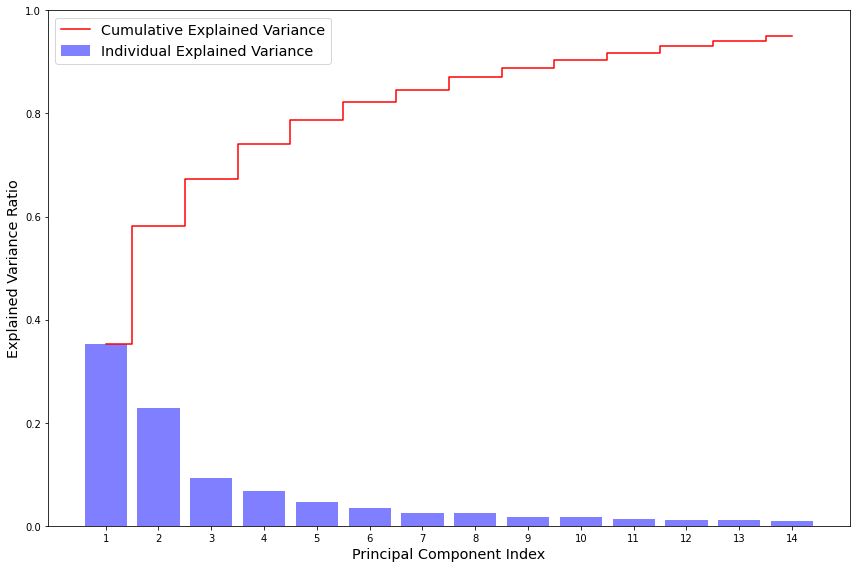

In [96]:
# Create the visualization plot
fontsize = 'x-large'
plt.figure(figsize=(12, 8))
plt.xticks(range(1, len(exp_var_pca)+1, 1))
plt.yticks(np.linspace(0,1,6))
plt.ylim(0,1)
plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center', color='blue', label='Individual Explained Variance')
plt.step(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid', color='red', label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio', fontsize=fontsize)
plt.xlabel('Principal Component Index', fontsize=fontsize)
plt.legend(loc='best', fontsize=fontsize)
plt.tight_layout()
plt.show()

In [36]:
cumulative_explained_variances = {}

for n_components in range (1, 21):
    pca = PCA(n_components=n_components)
    pca.fit(train_data_pca_x)
    X_train_pca = pca.fit_transform(X_train_std)
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.sum(explained_variance)
    cumulative_explained_variances[n_components] = cumulative_explained_variance

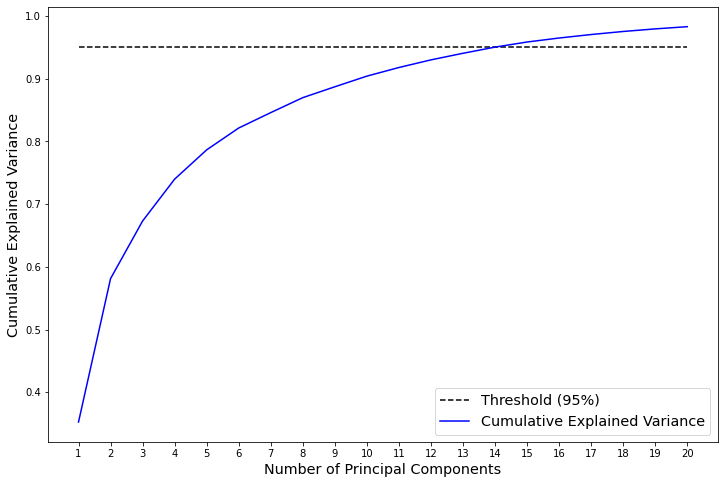

In [100]:
x = list(cumulative_explained_variances.keys())
y = list(cumulative_explained_variances.values())

fontsize = 'x-large'
plt.figure(figsize=(12, 8))
plt.xlabel('Number of Principal Components', fontsize=fontsize)
plt.ylabel('Cumulative Explained Variance', fontsize=fontsize)
plt.xticks(x)
#plt.ylim(0,1)
#plt.axhline(y=0.95, color='black', linestyle='dashed', label='Threshold (95%)')
plt.plot(x, [0.95]*len(x), color='black', linestyle='dashed', label='Threshold (95%)')
plt.plot(x, y, color='blue', label='Cumulative Explained Variance')
plt.legend(loc='lower right', fontsize=fontsize)
plt.show()

In [203]:
import os
import sys
import torch
import numpy as np
from src.custom_types import Behavior, MTDTechnique
from tabulate import tabulate

def split_data(data, split=0.8):
    row = int(len(data) * split)
    X_train = data[:row, :-1].astype(np.float32)
    X_valid = data[row:, :-1].astype(np.float32)
    return X_train, X_valid
    
training_data, test_data, _ = DataProvider.get_scaled_train_test_split(pi=PI, scaling_minmax=True,
                                                                         scale_normal_only=True)
normal_data = training_data[b]
threshold = int(len(normal_data) * 0.5)

training_data[b] = normal_data[:threshold]

ae_training_data = normal_data[threshold:]  # use remaining samples for autoencoder
ae_training_x, ae_valid_x = split_data(ae_training_data)

flattend_test_data = np.empty([0,47])
for behavior, behavior_data in test_data.items():
    if behavior == Behavior.NORMAL:
        n_samples = 2800
        behavior_data[:, -1] =  0
    else:
        n_samples = 400
        behavior_data[:, -1] = 1
    #y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * n_samples)
    
    flattend_test_data = np.concatenate((flattend_test_data, behavior_data[:n_samples]), axis=0)

ae_test_x = flattend_test_data[:,:-1]
ae_test_y = flattend_test_data[:,-1].astype(int)

evaluation_data = {}
for behavior, behavior_data in training_data.items():
    if behavior == Behavior.NORMAL:
        evaluation_data[behavior] = behavior_data[:2800]
    else:
        evaluation_data[behavior] = behavior_data[:400]

In [218]:
from torch import nn
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score

def initial_autoencoder_architecture():
    return nn.Sequential(
        nn.Linear(46, 23),
        nn.BatchNorm1d(23),
        nn.GELU(),
        nn.Linear(23, 11),
        nn.GELU(),
        nn.Linear(11, 23),
        nn.BatchNorm1d(23),
        nn.GELU(),
        nn.Linear(23, 46),
        nn.GELU()
    )

class AutoEncoder(torch.nn.Module):
    

    def __init__(self, model, X_valid, X_test, y_test, evaluation_data, num_stds=[1], activation_function=torch.nn.ReLU(), batch_size: int = 64, verbose=False):

        super().__init__()
        
        validation_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_valid).type(torch.float),

        )
        self.validation_data_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=True, drop_last=True)

        self.X_test = X_test
        self.y_test = y_test
        
        self.evaluation_data = evaluation_data
        self.num_stds = num_stds
        
        n_features = X_test.shape[1]
        
        self.model = model
        self.threshold = None
        self.loss_mean = None
        self.loss_standard_deviation = None
        
        self.verbose = verbose

        
    def forward(self, X):
        return self.model(X)
    
    
    def pretrain(self, X_train, optimizer=torch.optim.SGD, loss_function=torch.nn.MSELoss(reduction='sum'), num_epochs: int = 15, batch_size=64, verbose=False):
        
        training_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_train).type(torch.float),
        )
        training_data_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        epoch_losses = []
        #for e in tqdm(range(num_epochs), unit="epoch", leave=False):
        for e in range(num_epochs):
            self.train()
            current_losses = []
            for batch_index, (inputs,) in enumerate(training_data_loader):
                optimizer.zero_grad()
                outputs = self.forward(inputs)
                loss = loss_function(inputs, outputs)
                loss.backward()
                optimizer.step()
                current_losses.append(loss.item())
            
            epoch_losses.append(np.average(current_losses))
            if verbose:
                print(f'Training Loss in epoch {e + 1}: {epoch_losses[e]}')
            
        self.analyze_loss()

    '''
    This function uses normal data samles 
    after training the autoencoder to determine
    values that can be considered normal
    for the reconstruction loss based on normal samples
    '''
    def analyze_loss(self):
        losses = []
        
        self.eval() 
        with torch.no_grad():
            loss_function = torch.nn.MSELoss(reduction='sum')
            for batch_index, (inputs,) in enumerate(self.validation_data_loader):
                outputs = self.forward(inputs)
                loss = loss_function(inputs, outputs)
                losses.append(loss.item())
        
        losses = np.array(losses)

        self.loss_mean = losses.mean()
        self.loss_standard_deviation = losses.std()

        
    def predict(self, x, num_std = 1):
        test_data = torch.utils.data.TensorDataset(
            torch.from_numpy(x).type(torch.float32)
        )
        test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

        all_predictions = torch.tensor([])  # .cuda()

        self.eval()
        with torch.no_grad():
            ae_loss = torch.nn.MSELoss(reduction="sum")
            for idx, (batch_x,) in enumerate(test_data_loader):
                model_predictions = self.forward(batch_x)
                model_predictions = ae_loss(model_predictions, batch_x).unsqueeze(0)  # unsqueeze as batch_size set to 1
                all_predictions = torch.cat((all_predictions, model_predictions))

        threshold = self.loss_mean + num_std * self.loss_standard_deviation
        all_predictions = (all_predictions > threshold).type(torch.long)
        return all_predictions.flatten()
    
    
    def predict_deviation(self, x):
        test_data = torch.utils.data.TensorDataset(
            torch.from_numpy(x).type(torch.float32)
        )
        test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

        prediction_errors = torch.tensor([])
        loss_function = torch.nn.MSELoss(reduction="sum")
        
        self.eval()
        with torch.no_grad():
            
            for batch_index, (inputs,) in enumerate(test_data_loader):
                prediction = self.forward(inputs)
                prediction_error = loss_function(inputs, prediction).unsqueeze(0)  # unsqueeze as batch_size set to 1
                prediction_errors = torch.cat((prediction_errors, prediction_error))

        return prediction_errors
    
    
    def score(self):
        num_std, accuracy = self.accuracy_score(None, None)
        if self.verbose:
            print(f"Highest validation accuracy achieved {accuracy:.2f} with num_std={num_std}")
            self.evaluate(num_std)
        return accuracy
    
    
    def accuracy_score(self, X, y):
        #if not self.threshold:
        #loss_mean, loss_standard_deviation = self.analyze_loss(X)
        #num_stds = np.arange(0.1, 3, 0.1)
        if self.loss_mean == None or self.loss_standard_deviation == None:
              #print("accuracy_score_optimized > accurcy_loss()")
              self.analyze_loss()
    
        best_accuracy = 0
        best_num_std = 0
        #accuracies = []
        y_dev = self.predict_deviation((self.X_test).astype(np.float32))
        for num_std in self.num_stds:
            y_true = self.y_test
            threshold = self.loss_mean + num_std * self.loss_standard_deviation
            y_pred = (y_dev > threshold).type(torch.long).detach().cpu().numpy()
            
            accuracy = accuracy_score(y_true, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_std = num_std
            #if self.verbose:
            #    print(f"num_std {num_std:.2f} -> accuracy: {accuracy}")

        return best_num_std, best_accuracy
    
    
    def evaluate(self, num_std=0.1, tablefmt='pipe'):
        results = []
        labels= [0,1]
        pos_label = 1
        
        y_true_total = np.empty([0])
        y_pred_total = np.empty([0])
        for behavior, data in self.evaluation_data.items():
            y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * len(data)).astype(int)
            y_true_total = np.concatenate((y_true_total, y_true))

            y_pred = self.predict(data[:, :-1].astype(np.float32), num_std=num_std)
            y_pred_total = np.concatenate((y_pred_total, y_pred))

            accuracy = accuracy_score(y_true, y_pred)

            n_samples = len(y_true)
            results.append([behavior.name.replace("_", "\_"), f'{(100 * accuracy):.2f}\%', '\\notCalculated', '\\notCalculated', '\\notCalculated', str(n_samples)])

        accuracy = accuracy_score(y_true_total, y_pred_total)
        precision = precision_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        recall = recall_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        f1 = f1_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        n_samples = len(y_true_total)
        results.append(["GLOBAL", f'{(100 * accuracy):.2f}\%', f'{(100 * precision):.2f}\%', f'{(100 * recall):.2f}\%', f'{(100 * f1):.2f}\%', n_samples])
        print("-----------")
        print(tabulate(results, headers=["Behavior", "Accuracy", "Precision", "Recall", "F1-Score", "\#Samples"], tablefmt=tablefmt)) 

### 4.2 Autoencoder > Initial Architecture Evaluation

In [254]:
initial_autoencoder = AutoEncoder(initial_autoencoder_architecture(), ae_valid_x, ae_test_x, ae_test_y, evaluation_data)
initial_autoencoder.pretrain(ae_training_x, optimizer=torch.optim.SGD(autoencoder.parameters(), lr=1e-4, momentum=0.9), num_epochs=100, batch_size=64, verbose=False)
initial_autoencoder.evaluate(num_std=2.5, tablefmt='latex_raw')

-----------
\begin{tabular}{llllll}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       & #Samples   \\
\hline
 NORMAL                   & 86.39\%    & \notCalculated & \notCalculated & \notCalculated & \2800      \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated & \400       \\
 ROOTKIT\_BDVL            & 95.75\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 ROOTKIT\_BEURK           & 17.25\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_THETICK             & 10.00\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_BACKDOOR\_JAKORITAR & 6.50\%     & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_OPT1                & 44.00\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated & \400      

### 4.3 Autoencoder > Hyperparameter Search

In [214]:
import skorch
from skorch import NeuralNet, NeuralNetRegressor
from skorch.scoring import loss_scoring

class StateAnomalyDetector(skorch.NeuralNet):
    def score(self, X, y=None):
        return self.module_.score()
    
    def evaluate(self):
        self.module_.evaluate()

In [215]:
from skorch import NeuralNet, NeuralNetRegressor
from skorch.callbacks import LRScheduler, EarlyStopping

state_anomaly_detector = StateAnomalyDetector(
    module=AutoEncoder,
    
    criterion=torch.nn.MSELoss(reduction='mean'),
    optimizer=torch.optim.SGD,
    optimizer__lr=0.0001,
    optimizer__weight_decay=0.01,
    
    iterator_train__shuffle=True,
    max_epochs=20,
    batch_size=32,
    
    module__model=initial_autoencoder_architecture(),
    module__X_valid=ae_valid_x,
    module__X_test=ae_test_x,
    module__y_test=ae_test_y,
    module__evaluation_data=evaluation_data,
    module__activation_function=nn.GELU(),
    module__num_stds=np.linspace(0.1, 3, 30),
    module__verbose=True,
    
    verbose=True,
    
    callbacks=[EarlyStopping(patience=5, monitor='valid_loss')]

)

In [148]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [220]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'verbose': [False],
    'criterion': [RMSELoss, torch.nn.L1Loss, torch.nn.MSELoss],
    'optimizer': [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop],
    'lr': [0.0001, 0.00001],
    'max_epochs': [20],
    'batch_size': [64],
    #'module__activation_function': [torch.nn.Tanh(), torch.nn.GELU(), torch.nn.ReLU(), torch.nn.Sigmoid(), torch.nn.ELU()],
    'module__activation_function': [torch.nn.GELU()],
}

ae_grid_search_01 = GridSearchCV(estimator=state_anomaly_detector,
                                 param_grid=param_grid,
                                 n_jobs=1,
                                 cv=3,
                                 verbose=10,
                                 refit=False,
                                )
ae_grid_search_01_result = ae_grid_search_01.fit(ae_training_x, ae_training_x)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/18] START batch_size=64, criterion=<class '__main__.RMSELoss'>, lr=0.0001, max_epochs=20, module__activation_function=GELU(approximate='none'), optimizer=<class 'torch.optim.adam.Adam'>, verbose=False
Highest validation accuracy achieved 0.70 with num_std=2.8
-----------
| Behavior                 | Accuracy   | Precision      | Recall         | F1-Score       | #Samples   |
|:-------------------------|:-----------|:---------------|:---------------|:---------------|:-----------|
| NORMAL                   | 97.89\%    | \notCalculated | \notCalculated | \notCalculated | \2800      |
| RANSOMWARE\_POC          | 100.00\%   | \notCalculated | \notCalculated | \notCalculated | \400       |
| ROOTKIT\_BDVL            | 99.50\%    | \notCalculated | \notCalculated | \notCalculated | \400       |
| ROOTKIT\_BEURK           | 3.25\%     | \notCalculated | \notCalculated | \notCalculated | \400       |
| CNC\_THETICK      

In [221]:
ae_grid_search_01_result_table = convert_grid_search_result(ae_grid_search_01_result)
display_grid_search_result(ae_grid_search_01_result_table)

\begin{tabular}{lrrlrrlll}
\toprule
{} &  mean\_validation\_accuracy &  batch\_size &                                criterion &       lr &  max\_epochs & module\_\_activation\_function &                              optimizer &  verbose \\
\midrule
\textbf{1 } &                  0.710714 &          64 &  <class 'torch.nn.modules.loss.MSELoss'> &  0.00010 &          20 &    GELU(approximate='none') &          <class 'torch.optim.sgd.SGD'> &    False \\
\textbf{2 } &                  0.710238 &          64 &  <class 'torch.nn.modules.loss.MSELoss'> &  0.00001 &          20 &    GELU(approximate='none') &          <class 'torch.optim.sgd.SGD'> &    False \\
\textbf{3 } &                  0.710238 &          64 &   <class 'torch.nn.modules.loss.L1Loss'> &  0.00010 &          20 &    GELU(approximate='none') &          <class 'torch.optim.sgd.SGD'> &    False \\
\textbf{4 } &                  0.710119 &          64 &              <class '\_\_main\_\_.RMSELoss'> &  0.00001 &          20 &  

In [240]:
ae_grid_search_01_result_table.head(10)

,mean_validation_accuracy,batch_size,criterion,lr,max_epochs,module__activation_function,optimizer,verbose
1,0.710714,64,<class 'torch.nn.modules.loss.MSELoss'>,0.00010,20,GELU(approximate='none'),<class 'torch.optim.sgd.SGD'>,False
2,0.710238,64,<class 'torch.nn.modules.loss.MSELoss'>,0.00001,20,GELU(approximate='none'),<class 'torch.optim.sgd.SGD'>,False
3,0.710238,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00010,20,GELU(approximate='none'),<class 'torch.optim.sgd.SGD'>,False
4,0.710119,64,<class '__main__.RMSELoss'>,0.00001,20,GELU(approximate='none'),<class 'torch.optim.sgd.SGD'>,False
5,0.709940,64,<class '__main__.RMSELoss'>,0.00010,20,GELU(approximate='none'),<class 'torch.optim.sgd.SGD'>,False
6,0.709821,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00001,20,GELU(approximate='none'),<class 'torch.optim.sgd.SGD'>,False
7,0.707976,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00010,20,GELU(approximate='none'),<class 'torch.optim.rmsprop.RMSprop'>,False
8,0.707024,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00001,20,GELU(approximate='none'),<class 'torch.optim.adam.Adam'>,False
9,0.706964,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00010,20,GELU(approximate='none'),<class 'torch.optim.adam.Adam'>,False
10,0.705833,64,<class 'torch.nn.modules.loss.MSELoss'>,0.00001,20,GELU(approximate='none'),<class 'torch.optim.adam.Adam'>,False


In [244]:
autoencoder = AutoEncoder(initial_autoencoder_architecture(), ae_valid_x, ae_test_x, ae_test_y, evaluation_data)
autoencoder.pretrain(ae_training_x, optimizer=torch.optim.Adam(autoencoder.parameters(), lr=1e-4,  weight_decay=0.01), loss_function=RMSELoss(), num_epochs=100, batch_size=64, verbose=True)
autoencoder.evaluate(num_std=2.5, tablefmt='latex_raw')

Training Loss in epoch 1: 0.38266986757516863
Training Loss in epoch 2: 0.3630200415849686
Training Loss in epoch 3: 0.343880536655585
Training Loss in epoch 4: 0.32566845367352165
Training Loss in epoch 5: 0.3085550680756569
Training Loss in epoch 6: 0.2925955613454183
Training Loss in epoch 7: 0.27672968556483585
Training Loss in epoch 8: 0.2608952489991983
Training Loss in epoch 9: 0.24446614558498064
Training Loss in epoch 10: 0.2290728601316611
Training Loss in epoch 11: 0.2139025780061881
Training Loss in epoch 12: 0.1999205191930135
Training Loss in epoch 13: 0.18690573771794636
Training Loss in epoch 14: 0.17554601008693377
Training Loss in epoch 15: 0.16502170488238335
Training Loss in epoch 16: 0.15687555919090906
Training Loss in epoch 17: 0.14754326517383257
Training Loss in epoch 18: 0.1409994116673867
Training Loss in epoch 19: 0.13529607765376567
Training Loss in epoch 20: 0.12887703118224939
Training Loss in epoch 21: 0.12534602309266726
Training Loss in epoch 22: 0.121

### 4.4 Tied Autoencoder > Hyperparameter Search

In [230]:
import numpy as np
import torch.nn.functional as F

from torch import nn

class TiedAutoEncoder(AutoEncoder):
    

    def __init__(self, X_valid, X_test, y_test, evaluation_data, num_stds=[1], activation_function=torch.nn.ReLU(), batch_size: int = 64, verbose=False):
        
        super(TiedAutoEncoder, self).__init__(None, X_valid, X_test, y_test, evaluation_data)

        n_features = X_valid.shape[1]
        self.weight_matrix_1 = nn.Parameter(torch.randn(n_features, 30))
        self.weight_matrix_2 = nn.Parameter(torch.randn(30, 20))
        self.weight_matrix_3 = nn.Parameter(torch.randn(20, 10))
        
        
    def forward(self, x):
        x = F.relu(F.linear(x, self.weight_matrix_1.T))
        x = F.relu(F.linear(x, self.weight_matrix_2.T))
        x = F.relu(F.linear(x, self.weight_matrix_3.T))
        x = F.relu(F.linear(x, self.weight_matrix_3))
        x = F.relu(F.linear(x, self.weight_matrix_2))
        x = F.relu(F.linear(x, self.weight_matrix_1))
        return x

In [231]:
tied_state_anomaly_detector = StateAnomalyDetector(
    module=TiedAutoEncoder,
    
    criterion=torch.nn.MSELoss(reduction='mean'),
    optimizer=torch.optim.SGD,
    optimizer__lr=0.0001,
    optimizer__weight_decay=0.01,
    
    iterator_train__shuffle=True,
    max_epochs=20,
    batch_size=32,
    
    module__X_valid=ae_valid_x,
    module__X_test=ae_test_x,
    module__y_test=ae_test_y,
    module__evaluation_data=evaluation_data,
    module__activation_function=nn.GELU(),
    module__num_stds=np.linspace(0.1, 3, 30),
    module__verbose=True,
    
    verbose=False,
    
    callbacks=[EarlyStopping(patience=5, monitor='valid_loss')]
)

In [233]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'verbose': [False],
    'criterion': [RMSELoss, torch.nn.L1Loss, torch.nn.MSELoss],
    'optimizer': [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop],
    'lr': [0.0000001, 0.00000001],
    'max_epochs': [20],
    'batch_size': [64],
    #'module__activation_function': [torch.nn.Tanh(), torch.nn.GELU(), torch.nn.ReLU(), torch.nn.Sigmoid(), torch.nn.ELU()],
    'module__activation_function': [torch.nn.GELU()],
}

ae_grid_search_02 = GridSearchCV(estimator=tied_state_anomaly_detector,
                                 param_grid=param_grid,
                                 n_jobs=1,
                                 cv=3,
                                 verbose=3,
                                 refit=False,
                                 return_train_score=True,
                                )
ae_grid_search_02_result = ae_grid_search_02.fit(ae_training_x, ae_training_x)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END batch_size=64, criterion=<class '__main__.RMSELoss'>, lr=1e-07, max_epochs=20, module__activation_function=GELU(approximate='none'), optimizer=<class 'torch.optim.adam.Adam'>, verbose=False;, score=(train=0.677, test=0.677) total time=   1.8s
[CV 2/3] END batch_size=64, criterion=<class '__main__.RMSELoss'>, lr=1e-07, max_epochs=20, module__activation_function=GELU(approximate='none'), optimizer=<class 'torch.optim.adam.Adam'>, verbose=False;, score=(train=0.679, test=0.679) total time=   2.2s
[CV 3/3] END batch_size=64, criterion=<class '__main__.RMSELoss'>, lr=1e-07, max_epochs=20, module__activation_function=GELU(approximate='none'), optimizer=<class 'torch.optim.adam.Adam'>, verbose=False;, score=(train=0.688, test=0.688) total time=   1.6s
[CV 1/3] END batch_size=64, criterion=<class '__main__.RMSELoss'>, lr=1e-07, max_epochs=20, module__activation_function=GELU(approximate='none'), optimizer=<class 'torch.o

In [168]:
ae_grid_search_02_result_table = convert_grid_search_result(ae_grid_search_02_result)
display_grid_search_result(ae_grid_search_02_result_table)

\begin{tabular}{lrrlrrlllrl}
\toprule
{} &  mean\_validation\_accuracy &  batch\_size &                                criterion &       lr &  max\_epochs & module\_\_activation\_function &  module\_\_verbose &                              optimizer &  optimizer\_\_weight\_decay &  verbose \\
\midrule
\textbf{1 } &                  0.711310 &          64 &   <class 'torch.nn.modules.loss.L1Loss'> &  0.00001 &          20 &    GELU(approximate='none') &             True &        <class 'torch.optim.adam.Adam'> &                     0.01 &    False \\
\textbf{2 } &                  0.703393 &          64 &   <class 'torch.nn.modules.loss.L1Loss'> &  0.00010 &          20 &    GELU(approximate='none') &             True &        <class 'torch.optim.adam.Adam'> &                     0.01 &    False \\
\textbf{3 } &                  0.700893 &          64 &   <class 'torch.nn.modules.loss.L1Loss'> &  0.00001 &          20 &    GELU(approximate='none') &             True &  <class 'torch.opt

In [234]:
ae_grid_search_02_result_table.head(10)

,mean_validation_accuracy,batch_size,criterion,lr,max_epochs,module__activation_function,module__verbose,optimizer,optimizer__weight_decay,verbose
1,0.711310,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00001,20,GELU(approximate='none'),True,<class 'torch.optim.adam.Adam'>,0.01,False
2,0.703393,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00010,20,GELU(approximate='none'),True,<class 'torch.optim.adam.Adam'>,0.01,False
3,0.700893,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00001,20,GELU(approximate='none'),True,<class 'torch.optim.rmsprop.RMSprop'>,0.01,False
4,0.700119,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00001,20,GELU(approximate='none'),True,<class 'torch.optim.sgd.SGD'>,0.01,False
5,0.697738,64,<class '__main__.RMSELoss'>,0.00010,20,GELU(approximate='none'),True,<class 'torch.optim.adam.Adam'>,0.01,False
6,0.697500,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00010,20,GELU(approximate='none'),True,<class 'torch.optim.rmsprop.RMSprop'>,0.01,False
7,0.695476,64,<class '__main__.RMSELoss'>,0.00001,20,GELU(approximate='none'),True,<class 'torch.optim.rmsprop.RMSprop'>,0.01,False
8,0.691429,64,<class 'torch.nn.modules.loss.MSELoss'>,0.00010,20,GELU(approximate='none'),True,<class 'torch.optim.rmsprop.RMSprop'>,0.01,False
9,0.689762,64,<class '__main__.RMSELoss'>,0.00010,20,GELU(approximate='none'),True,<class 'torch.optim.rmsprop.RMSprop'>,0.01,False
10,0.689345,64,<class 'torch.nn.modules.loss.MSELoss'>,0.00001,20,GELU(approximate='none'),True,<class 'torch.optim.rmsprop.RMSprop'>,0.01,False


In [245]:
tied_autoencoder = TiedAutoEncoder(ae_valid_x, ae_test_x, ae_test_y, evaluation_data, num_stds=[2.5], activation_function=torch.nn.GELU(), batch_size=64)
tied_autoencoder.pretrain(ae_training_x, optimizer=torch.optim.Adam(tied_autoencoder.parameters(), lr=0.00001) ,loss_function=torch.nn.L1Loss(), num_epochs=100, batch_size=64, verbose=True)
tied_autoencoder.evaluate(num_std=2.5, tablefmt='latex_raw')

Training Loss in epoch 1: 435.89940134684247
Training Loss in epoch 2: 430.4549560546875
Training Loss in epoch 3: 424.53600921630857
Training Loss in epoch 4: 418.6495519002279
Training Loss in epoch 5: 413.1371587117513
Training Loss in epoch 6: 407.61169484456383
Training Loss in epoch 7: 402.2019948323568
Training Loss in epoch 8: 396.82637176513674
Training Loss in epoch 9: 391.7884450276693
Training Loss in epoch 10: 386.6036010742188
Training Loss in epoch 11: 381.40386962890625
Training Loss in epoch 12: 376.47752075195314
Training Loss in epoch 13: 371.2980422973633
Training Loss in epoch 14: 366.6408126831055
Training Loss in epoch 15: 361.86222483317056
Training Loss in epoch 16: 356.9101760864258
Training Loss in epoch 17: 352.3812611897786
Training Loss in epoch 18: 347.8084070841471
Training Loss in epoch 19: 343.08237609863284
Training Loss in epoch 20: 338.74907836914065
Training Loss in epoch 21: 334.3351486206055
Training Loss in epoch 22: 329.77307586669923
Training 